In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools")
import plotTools as ptools
import json
from XRootD import client
xrdClient = client.FileSystem("root://cmseos.fnal.gov")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
f_sig = "signal_2018_aEM.coffea"
sig = util.load(f_sig)[0]
with open("signal_2018_aEM.json","r") as f:
    sig_info = json.load(f)
sig_info = {k['name'].replace(".","p"):k for k in sig_info}

In [4]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

sig_2018_Mchi-10p5_dMchi-1p0_ctau-1 5
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1 5
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1 5
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1 1
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1 5
sig_2018_Mchi-10p5_dMchi-1p0_ctau-10 5
sig_2018_Mchi-21p0_dMchi-2p0_ctau-10 5
sig_2018_Mchi-31p5_dMchi-3p0_ctau-10 5
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10 5
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10 5
sig_2018_Mchi-10p5_dMchi-1p0_ctau-100 5
sig_2018_Mchi-21p0_dMchi-2p0_ctau-100 5
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100 5
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100 5
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100 5
sig_2018_Mchi-10p5_dMchi-1p0_ctau-1000 5
sig_2018_Mchi-21p0_dMchi-2p0_ctau-1000 5
sig_2018_Mchi-31p5_dMchi-3p0_ctau-1000 5
sig_2018_Mchi-42p0_dMchi-4p0_ctau-1000 5
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1000 5
sig_2018_Mchi-11p0_dMchi-2p0_ctau-1 5
sig_2018_Mchi-22p0_dMchi-4p0_ctau-1 5
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1 5
sig_2018_Mchi-44p0_dMchi-8p0_ctau-1 5
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1 5
sig_2018_Mchi-11p0_

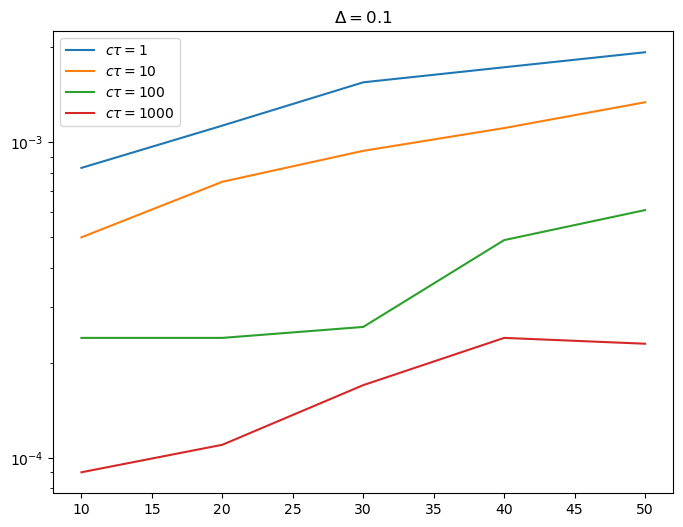

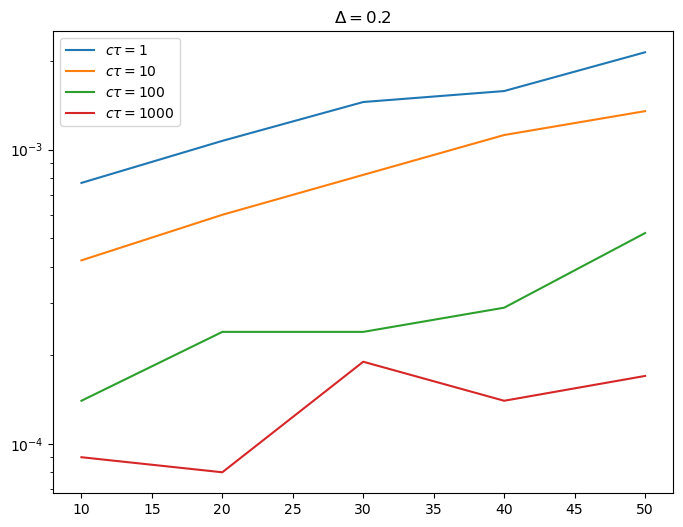

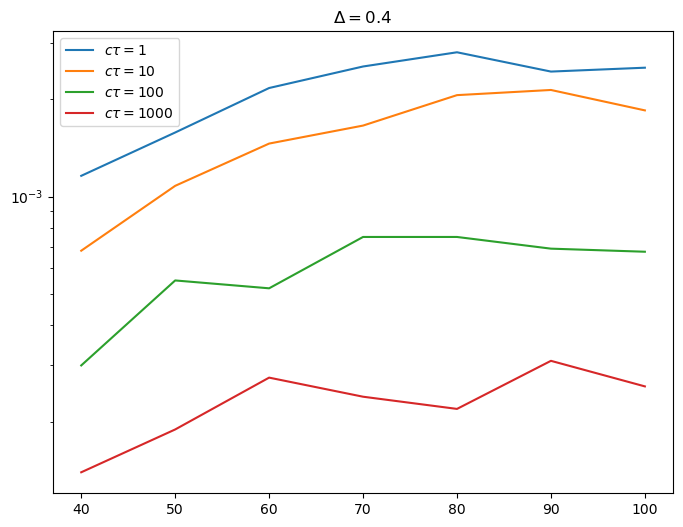

In [5]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
for d in deltas:
    plt.figure(figsize=(8,6))
    for ct in ctaus:
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            AOD_loc = '/store/group/lpcmetx/iDMe//Samples/AOD/'+'_'.join(name.split('_')[2:])
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            print(name,nfiles)
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            #n_targ = len(
            effs.append(nev/n_targ)
            
        plt.plot(m1s,effs,label=r"$c\tau = {0}$".format(ct))
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.yscale('log')

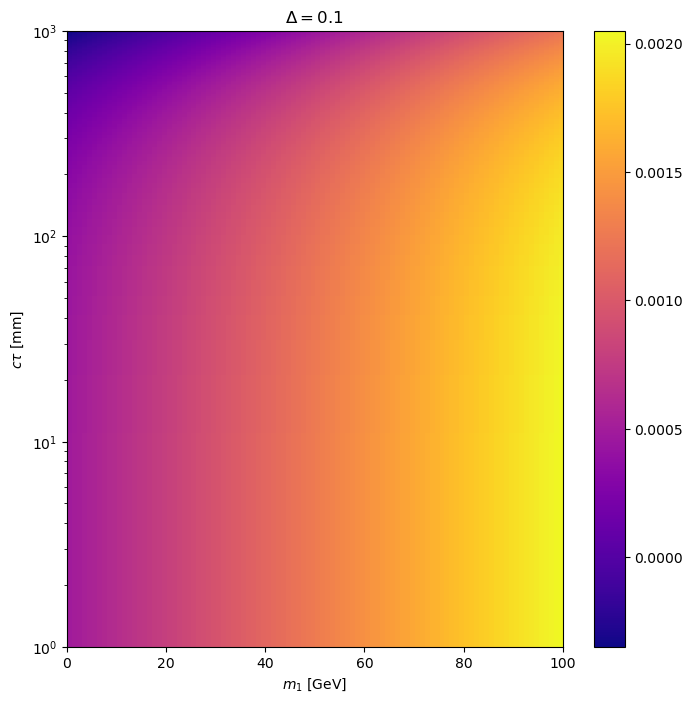

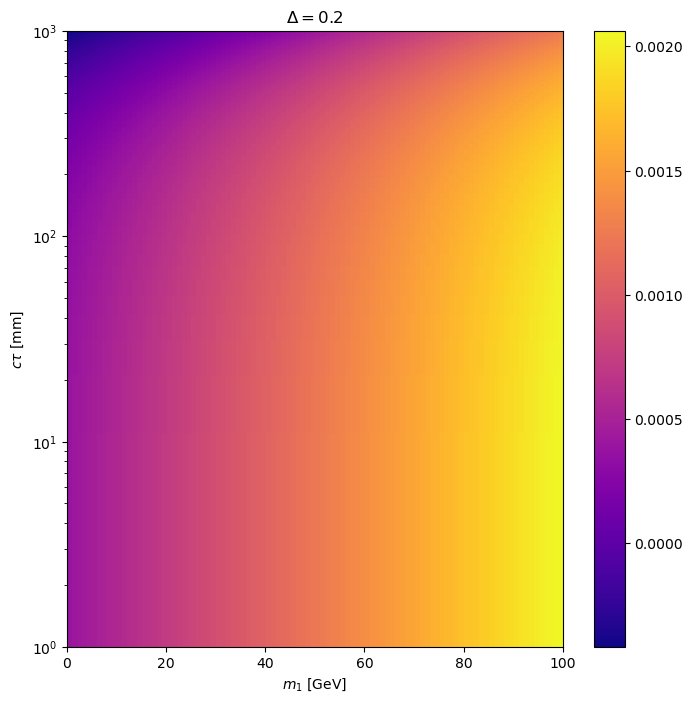

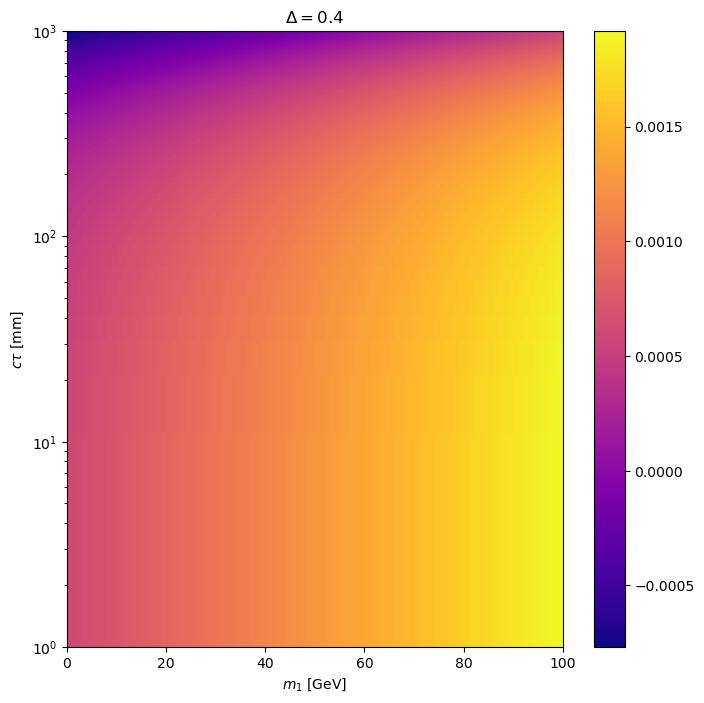

In [6]:
from sklearn.linear_model import LinearRegression
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
fits = {}
for d in deltas:
    plt.figure(figsize=(8,8))
    m1s = sorted(list(set(si[(si.delta==d)].m1.to_numpy())))
    m1_range = np.linspace(0,100,100)
    ct_range = np.linspace(1,1000,100)
    x = []
    y = []
    z = []
    for ct in ctaus:
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            x.append(m1)
            y.append(ct)
            z.append(nev/n_targ)
    fit_x = np.concatenate((np.array(x).reshape(-1,1),np.array(y).reshape(-1,1)),axis=1)
    fit = LinearRegression().fit(fit_x,z)
    fits[d] = fit
    X,Y = np.meshgrid(m1_range,ct_range)
    pts = np.vstack((X.ravel(),Y.ravel())).T
    interp = fit.predict(pts).reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(interp,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto')
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

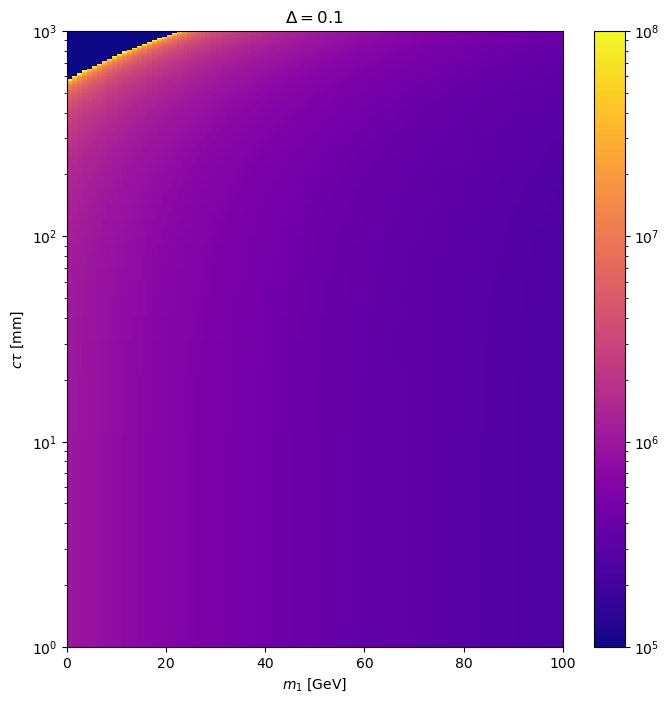

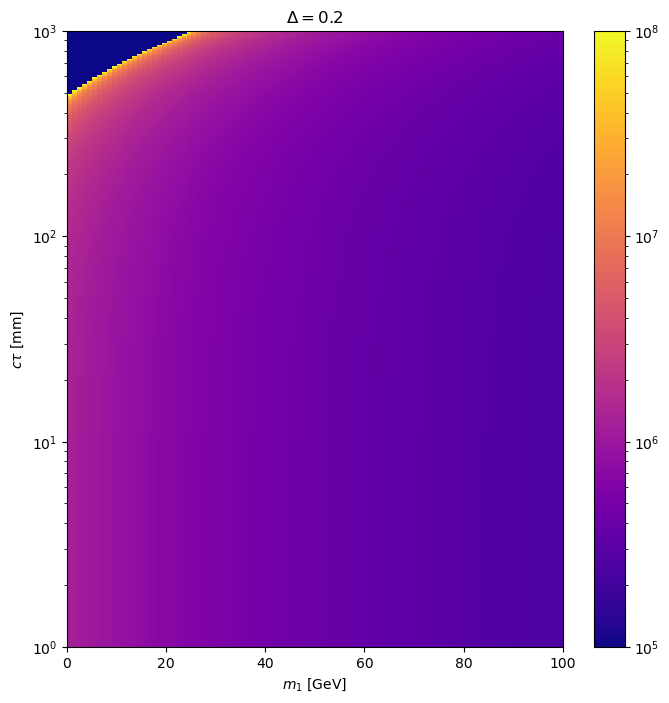

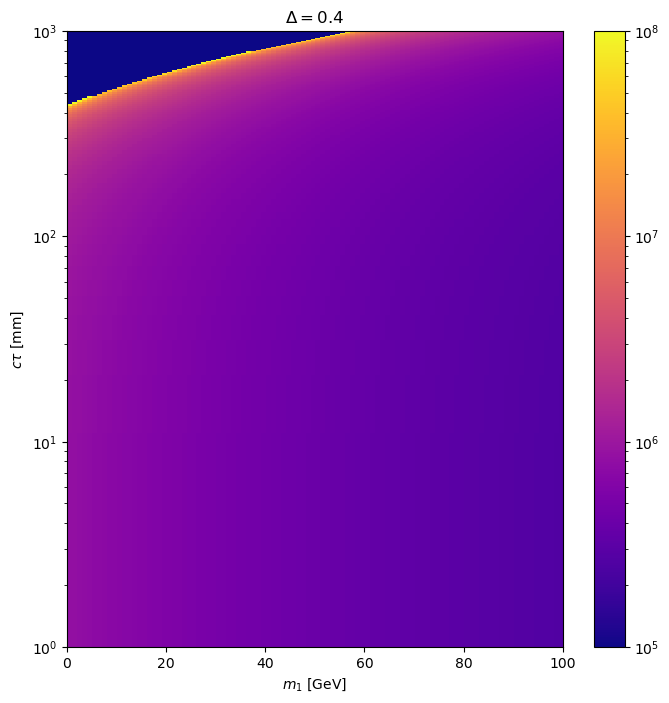

In [7]:
m1_range = np.linspace(0,100,100)
ct_range = np.linspace(1,1000,100)
X,Y = np.meshgrid(m1_range,ct_range)
pts = np.vstack((X.ravel(),Y.ravel())).T
from matplotlib.colors import LogNorm
target_nev = 500
for d in deltas:
    plt.figure(figsize=(8,8))
    effs = fits[d].predict(pts)
    effs[effs<1e-6] = target_nev
    ngen = target_nev/effs
    ngen = ngen.reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(ngen,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto',norm=LogNorm(vmin=1e5,vmax=1e8))
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

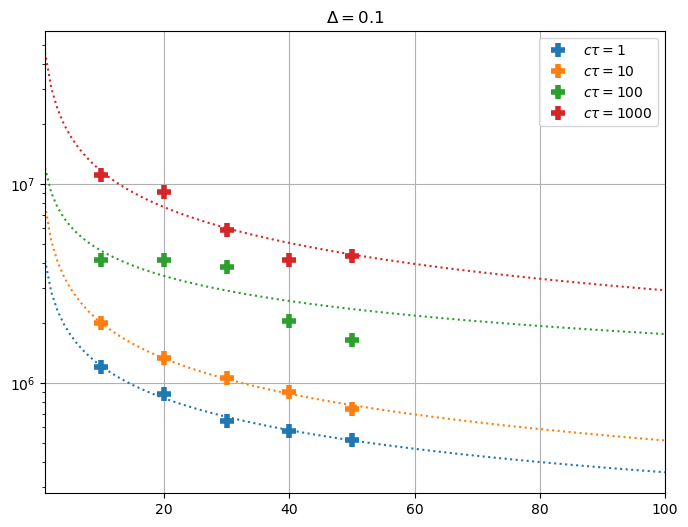

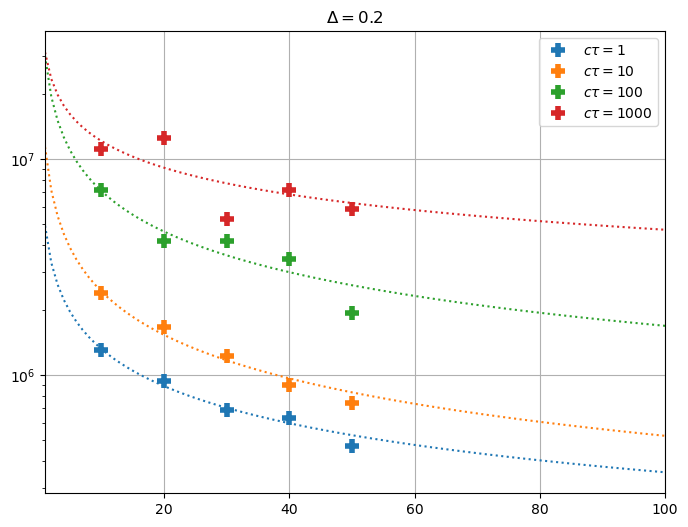

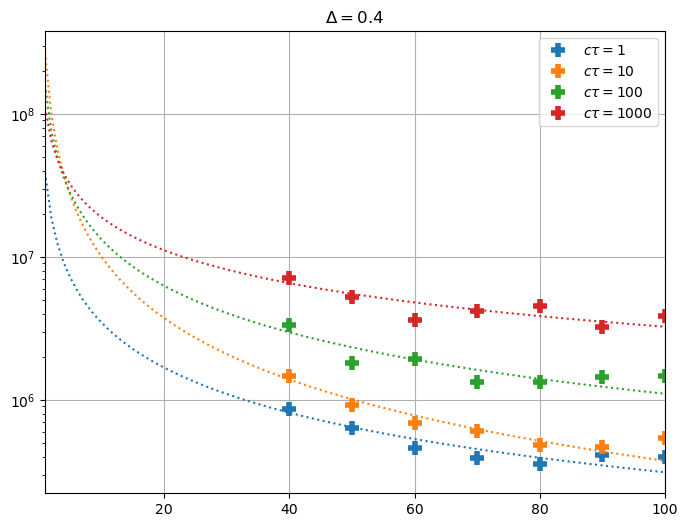

In [8]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        nums = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[name] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    #plt.ylim([1e5,1e7])
    plt.yscale('log')
    plt.grid()

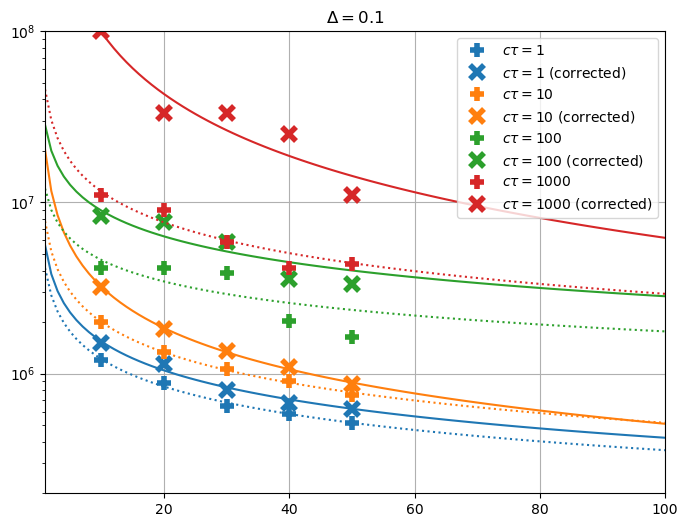

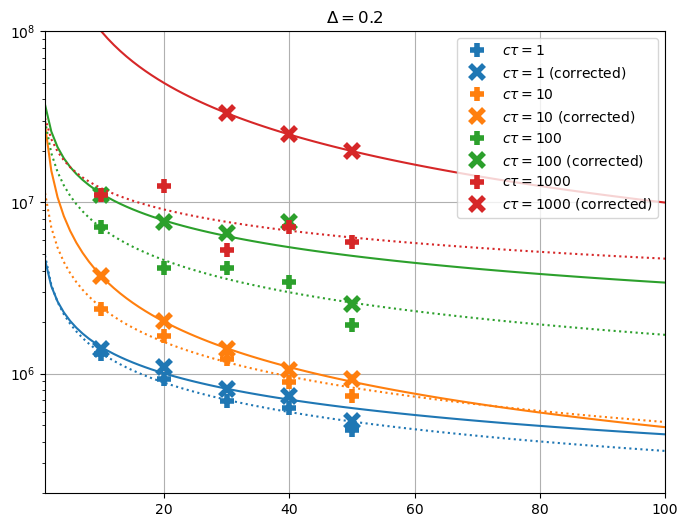

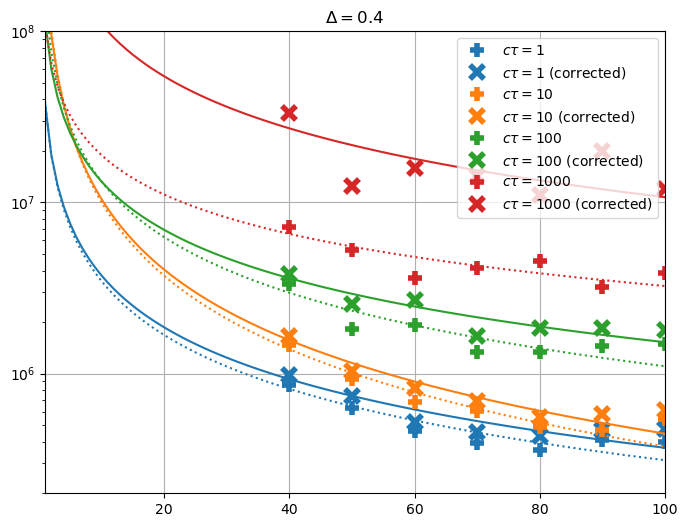

In [9]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
fits_corr = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        bad_m1 = [] 
        nums = []
        nums_corr = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
            match_categories = sig['sel_vtx_matchType'][{'samp':name,'cut':cut}].values()
            purity = match_categories[2]/np.sum(match_categories)
            if purity==0:
                bad_m1.append(m1)
                continue
            nums_corr.append(want_in_sr/(nev*purity/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1s_corr = [m for m in m1s if m not in bad_m1]
        plt.plot(m1s_corr,nums_corr,color=f"C{i}",label=r"$c\tau = {0}$ (corrected)".format(ct),linewidth=0,marker='x',markersize=10,mew=4)
        
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[f"delta{d:.1f}_ct{ct}"] = p_inv
        p_inv, cov_inv = curve_fit(f_inv, m1s_corr, nums_corr)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle='-')
        fits_corr[f"delta{d:.1f}_ct{ct}"] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.ylim([2e5,1e8])
    plt.yscale('log')
    plt.grid()
    plt.savefig(f"plots/nEvent_estimates/estimates_delta{d}.pdf")

In [12]:
m1s = np.arange(10,110,10)
cts = [1,10,100,1000]
deltas = [0.1,0.2,0.3]
for d in deltas:
    for m1 in m1s:
        for ct in cts:
            mchi = f"{m1+d*m1/2:.1f}".replace(".","p")
            dmchi = f"{d*m1:.1f}".replace(".","p")
            name = f"delta{d:.1f}_ct{ct}"
            num = f_inv(m1,*fits[name])
            num_corr = f_inv(m1,*fits_corr[name])
            print(d,m1,ct,int(num),int(num_corr))

0.1 10 1 1216143 1542783
0.1 10 10 2003935 3216904
0.1 10 100 4614033 8964146
0.1 10 1000 11577977 98903393
0.1 20 1 840965 1044422
0.1 20 10 1331994 1847110
0.1 20 100 3454978 6336448
0.1 20 1000 7652503 42996770
0.1 30 1 677740 831316
0.1 30 10 1048916 1335208
0.1 30 100 2917113 5172656
0.1 30 1000 6006343 26412580
0.1 40 1 581529 707045
0.1 40 10 885362 1060590
0.1 40 100 2587079 4479018
0.1 40 1000 5057947 18692203
0.1 50 1 516412 623595
0.1 50 10 776277 887116
0.1 50 100 2357025 4005716
0.1 50 1000 4426722 14295351
0.1 60 1 468658 562778
0.1 60 10 697203 766662
0.1 60 100 2184327 3656373
0.1 60 1000 3969913 11482474
0.1 70 1 431745 516009
0.1 70 10 636665 677672
0.1 70 100 2048223 3384887
0.1 70 1000 3620665 9540681
0.1 80 1 402128 478650
0.1 80 10 588490 608979
0.1 80 100 1937199 3166064
0.1 80 1000 3343067 8126155
0.1 90 1 377695 447948
0.1 90 10 549032 554191
0.1 90 100 1844275 2984821
0.1 90 1000 3115930 7053594
0.1 100 1 357099 422157
0.1 100 10 515983 509372
0.1 100 100 1764

KeyError: 'delta0.3_ct1'

In [11]:
fits

{'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1': array([4.14171401e+06, 5.32195254e-01]),
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10': array([7.78272938e+06, 5.89248096e-01]),
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100': array([1.20623713e+07, 4.17351947e-01]),
 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1000': array([4.58154859e+07, 5.97379598e-01]),
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1': array([4.90668443e+06, 5.71169707e-01]),
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10': array([1.13565859e+07, 6.68967901e-01]),
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-100': array([2.9922231e+07, 6.2462102e-01]),
 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1000': array([3.11613484e+07, 4.10911483e-01]),
 'sig_2018_Mchi-120p0_dMchi-40p0_ctau-1': array([3.88275601e+07, 1.04748265e+00]),
 'sig_2018_Mchi-120p0_dMchi-40p0_ctau-10': array([2.69357748e+08, 1.42787516e+00]),
 'sig_2018_Mchi-120p0_dMchi-40p0_ctau-100': array([1.59701988e+08, 1.08022721e+00]),
 'sig_2018_Mchi-120p0_dMchi-40p0_ctau-1000': array([1.10305297e+08, 7.65359486e-01])}